In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.offline as po
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import os 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error


# Training data import

In [2]:
df = pd.read_csv('_raw/case1Data.txt')

# Training data prep

In [3]:
# NA values are by default strings, since there is a space in front
df = df.replace(' NaN', np.nan)

# ensure numeric dtype

for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

# isolate targets from the design matrix
y = df['y']
X = df.iloc[:,1::]

# for convenience, fix the column naming
# with no spaces

X.columns = [name.replace(' ', '') for name in X.columns]

cat_cols = [col for col in X.columns if 'C' in col]
cat_cols.remove('C_2') # because the training data only contains one label

In [4]:
# prep procedure for X
def prep_X(df):
        # NA values are by default strings, since there is a space in front
    df = df.replace(' NaN', np.nan)

    # ensure numeric dtype

    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except:
            pass

    # # isolate targets from the design matrix
    # y = df['y']
    # X = df.iloc[:,1::]

    # for convenience, fix the column naming
    # with no spaces

    df.columns = [name.replace(' ', '') for name in df.columns]
    return df


# Imputation of missing values


In [5]:
# function to impute NaN
def knn_imputer(X, n_neighbors, cat_cols):
    X_knn = X.copy()
    # using same preprocessing as before in order to maintain same recipe (continous variables)
    X_knn_cont = X_knn.loc[:,[col for col in X_knn.columns if 'x' in col]]
    X_knn_cont = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_knn_cont), columns=X_knn_cont.columns)

    # performing one-hot encoding before KNN imputation in order to avoid the model to assume some sort of ordinal relationship
    onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')

    # one hot encoding
    onehot_data = onehot.fit_transform(X_knn[cat_cols])
    onehot_columns = onehot.get_feature_names_out()

    # new df
    onehot_cat_df = pd.DataFrame(onehot_data, columns=onehot_columns)

    X_knn_scaled = pd.concat([X_knn_cont,onehot_cat_df], axis=1)
    # dropping the nan column
    nan_cols = [col for col in X_knn_scaled.columns if 'nan' in col]
    X_knn_scaled = X_knn_scaled.drop(columns=nan_cols)

    # KNNImputer
    knn_imputer = KNNImputer(n_neighbors=n_neighbors, weights="uniform")

    # Apply to dataset
    imputed_data = knn_imputer.fit_transform(X_knn_scaled)

    imputed_df = pd.DataFrame(imputed_data, columns=X_knn_scaled.columns)

    return imputed_df

# Nested CV procedure

In [7]:
# transform y
y = preprocessing.StandardScaler().fit_transform(np.reshape(y.values, (-1,1))).ravel()


In [ ]:
# Since RMSE is the required scoring parameter
# define RMSE scorer function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# make it into a default scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)


# Define the models
models = {
    'RandomForest': RandomForestRegressor(criterion='squared_error'),
    'ElasticNet': ElasticNet(max_iter=10000,
                             tol=0.001),
    'LinearRegression': LinearRegression()
}

# RF parameters to investigate
n_estimators = [10,25,50,100]
max_depth = [5, 10, 15,20, 25]
min_samples_leaf = [2, 4, 10]
min_samples_split = [2,4,10]

# ElNet parameters to investigate
alpha = np.logspace(-3,3,7)
l1_ratio = np.linspace(0.5,1,10)

# Define parameter grids for hyperparameter tuning
param_grids = {
    'RandomForest': {'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_leaf':min_samples_leaf,
                    'min_samples_split':min_samples_split},
    'ElasticNet': {'alpha': alpha,
                   'l1_ratio': l1_ratio},
    'LinearRegression': {}

}

# try LOOCV for both inner and outer loops (could be costly :D)
outer_cv = LeaveOneOut()
inner_cv = 10

nested_scores = []
model_name = []
k_neighbors = []
cv_results = []

for k in [3,5,8]:
    # rename design matrix for ease of use
    X_final = knn_imputer(X, k, cat_cols=cat_cols)


    for name, model in models.items():
        # Outer Loop
        for train_index, test_index in outer_cv.split(X_final):
            print(test_index)
            X_train, X_test = X_final.iloc[train_index], X_final.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Grid search inner loop
            grid_search = GridSearchCV(estimator=model, 
                                    param_grid=param_grids[name], 
                                    cv=inner_cv, 
                                    scoring=rmse_scorer,
                                    #verbose=2
                                    )
            grid_search.fit(X_train, y_train)

            # Evaluate on the test data
            y_pred = grid_search.predict(X_test)
            test_rmse = rmse(y_test, y_pred)
            nested_scores.append(test_rmse)
            model_name.append(name)
            cv_results.append(grid_search.best_params_)
            k_neighbors.append(k)

            #print(grid_search.best_params_)

        #Report nested cross-validation RMSE
        nested_rmse = np.mean(nested_scores)
        print("Nested CV RMSE:", nested_rmse)


In [20]:
df_cv = pd.DataFrame(cv_results)

In [21]:
df_cv[['rmse','model','k_neighbors']] = pd.DataFrame([nested_scores, model_name, k_neighbors]).T

In [19]:
#df_cv.to_excel('_raw/nestedCV_results.xlsx', index=False)

## Nested CV result analysis

In [6]:
df_cv = pd.read_excel('_raw/nestedCV_results.xlsx')

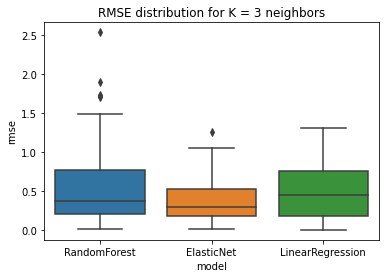

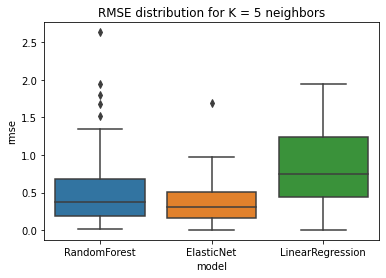

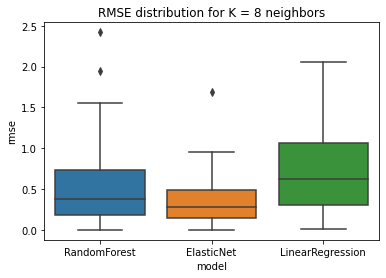

In [7]:
for k in df_cv.k_neighbors.unique():
    fig, ax = plt.subplots()
    sns.boxplot(
        data=df_cv.loc[df_cv.k_neighbors == k],
        x='model',
        y= 'rmse'
    )
    plt.title(f'RMSE distribution for K = {k} neighbors')
    plt.show()

In [8]:
# look at the mean RMSE values
df_cv[['k_neighbors','model','rmse']].groupby(by = ['k_neighbors','model'], as_index=False).mean().sort_values(by='rmse')

,k_neighbors,model,rmse
3,5,ElasticNet,0.351457
6,8,ElasticNet,0.351481
0,3,ElasticNet,0.367227
1,3,LinearRegression,0.485563
8,8,RandomForest,0.496515
5,5,RandomForest,0.522693
2,3,RandomForest,0.529098
7,8,LinearRegression,0.699857
4,5,LinearRegression,0.810934


In [9]:
#what is the target range?
y.max() - y.min()

# rmse of .3 does not seem too bad, also given that it comes from LOOCV.

5.361916954610165

### best Elnet params

In [10]:
# isolate elnet cv data
elnet_cv = df_cv.loc[df_cv.model == 'ElasticNet', ('l1_ratio','alpha','k_neighbors')]

elnet_cv

,l1_ratio,alpha,k_neighbors
100,0.555556,0.01,3
101,0.555556,0.01,3
102,0.555556,0.01,3
103,0.555556,0.01,3
104,0.777778,0.01,3
...,...,...,...
795,0.611111,0.01,8
796,0.722222,0.01,8
797,1.000000,0.01,8
798,0.722222,0.01,8


In [21]:
elnet_cv.loc[elnet_cv.k_neighbors == 5]['l1_ratio'].value_counts().values

array([94,  5,  1], dtype=int64)

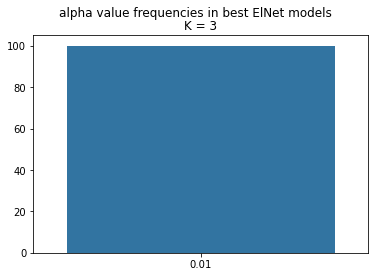

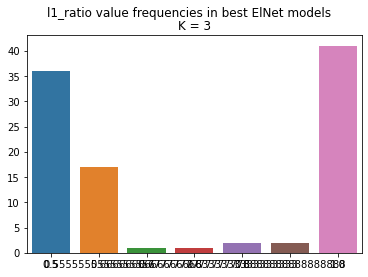

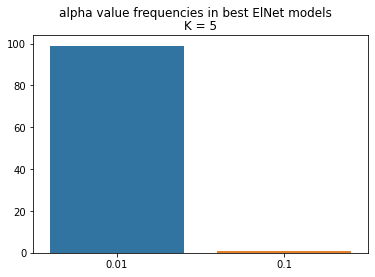

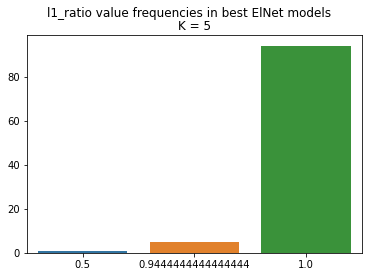

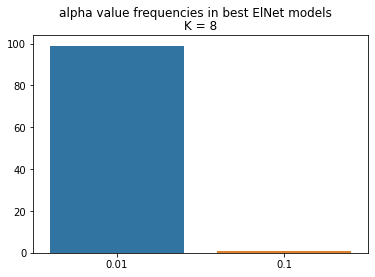

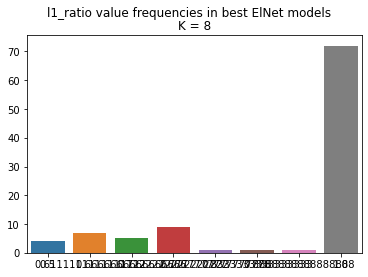

In [30]:
# for alpha and l1_ratio, plot value frequencies.

for k in elnet_cv.k_neighbors.unique():
    for param in ['alpha','l1_ratio']:
        data = elnet_cv.loc[elnet_cv.k_neighbors == k][param].value_counts().round(2)
        fig, ax = plt.subplots()
        sns.barplot(
            x = data.index,
            y = np.round(data.values, 2)
        )
        plt.suptitle(f'{param} value frequencies in best ElNet models')
        plt.title(f'K = {k}')

        plt.show()

In [29]:
data.values

array([72,  9,  7,  5,  4,  1,  1,  1], dtype=int64)

# LOOCV of the best model

In [18]:
# Since RMSE is the required scoring parameter
# define RMSE scorer function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# make it into a default scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)


# Define the models
models = {
    #'RandomForest': RandomForestRegressor(criterion='squared_error'),
    'ElasticNet': ElasticNet(max_iter=10000,
                             tol=0.001),
    #'LinearRegression': LinearRegression()
}

# RF parameters to investigate
n_estimators = [10,25,50,100]
max_depth = [5, 10, 15,20, 25]
min_samples_leaf = [2, 4, 10]
min_samples_split = [2,4,10]

# ElNet parameters to investigate
alpha = [0.01]
l1_ratio = [1]

# Define parameter grids for hyperparameter tuning
param_grids = {
    'RandomForest': {'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_leaf':min_samples_leaf,
                    'min_samples_split':min_samples_split},
    'ElasticNet': {'alpha': alpha,
                   'l1_ratio': l1_ratio},
    'LinearRegression': {}

}

# try LOOCV for both inner and outer loops (could be costly :D)
outer_cv = LeaveOneOut()
inner_cv = 2

nested_scores = []
model_name = []
k_neighbors = []
cv_results = []
y_predicted = []

for k in [5]:
    # rename design matrix for ease of use
    X_final = knn_imputer(X, k, cat_cols=cat_cols)


    for name, model in models.items():
        # Outer Loop
        for train_index, test_index in outer_cv.split(X_final):
            print(test_index)
            X_train, X_test = X_final.iloc[train_index], X_final.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Grid search inner loop
            grid_search = GridSearchCV(estimator=model, 
                                    param_grid=param_grids[name], 
                                    cv=inner_cv, 
                                    scoring=rmse_scorer,
                                    #verbose=2
                                    )
            grid_search.fit(X_train, y_train)

            # Evaluate on the test data
            y_pred = grid_search.predict(X_test)
            test_rmse = rmse(y_test, y_pred)
            nested_scores.append(test_rmse)
            model_name.append(name)
            cv_results.append(grid_search.best_params_)
            k_neighbors.append(k)
            y_predicted.append(y_pred[0])
            

            #print(grid_search.best_params_)

        #Report nested cross-validation RMSE
        nested_rmse = np.mean(nested_scores)
        print("Nested CV RMSE:", nested_rmse)

residuals = y - y_predicted

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[36]
[37]
[38]
[39]
[40]
[41]
[42]
[43]
[44]
[45]
[46]
[47]
[48]
[49]
[50]
[51]
[52]
[53]
[54]
[55]
[56]
[57]
[58]
[59]
[60]
[61]
[62]
[63]
[64]
[65]
[66]
[67]
[68]
[69]
[70]
[71]
[72]
[73]
[74]
[75]
[76]
[77]
[78]
[79]
[80]
[81]
[82]
[83]
[84]
[85]
[86]
[87]
[88]
[89]
[90]
[91]
[92]
[93]
[94]
[95]
[96]
[97]
[98]
[99]
Nested CV RMSE: 0.34248403626627133


In [86]:
# #save RMSE estimate
# np.savetxt('_raw/estimatedRMSE_s180875_s194778.txt',np.array([nested_rmse]))

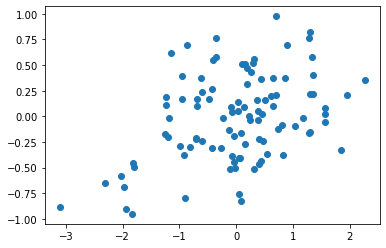

In [23]:
plt.scatter(y, residuals)

In [10]:
coefs =grid_search.best_estimator_.coef_

In [11]:
len(coefs[coefs != 0])

50

## Residual plots

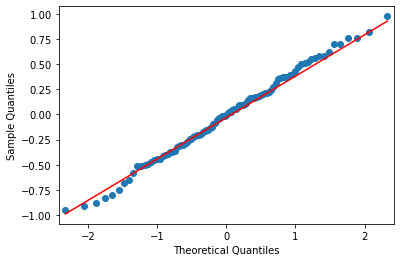

In [27]:
import statsmodels.api as sm 

  
# np.random generates different random numbers 
# whenever the code is executed 
# Note: When you execute the same code  
# the graph look different than shown below. 
  
# Random data points generated 
# data_points = np.random.normal(0, 1, 100)     
  
sm.qqplot(residuals, line ='q') 
plt.title()
plt.show()


## Fitting final prediction model

In [88]:
# prepare training a testing data
X_train = knn_imputer(X, 5, cat_cols=cat_cols)

X_new_raw = pd.read_csv('_raw/case1Data_Xnew.txt')
X_new = prep_X(X_new_raw)
X_test = knn_imputer(X_new, 5, cat_cols=cat_cols)

In [89]:
# ElNet parameters
alpha = 0.01
l1_ratio = 1

model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, tol=0.001, max_iter=10000)

model.fit(X_train, y)

y_pred = model.predict(X_train)
y_pred_new = model.predict(X_test)



In [93]:
# # save predicted values
# np.savetxt('_raw/predictions_s180875_s194778.txt', y_pred_new)

In [90]:
rmse(y, y_pred)

0.21821392275309967

Text(0.5, 1.0, 'predicted vs true')

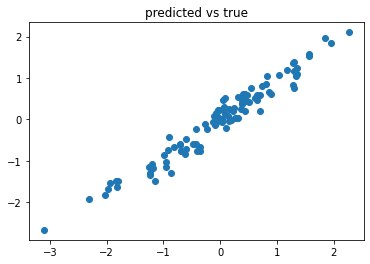

In [91]:
plt.scatter(x = y, y= y_pred)
plt.title('predicted vs true')

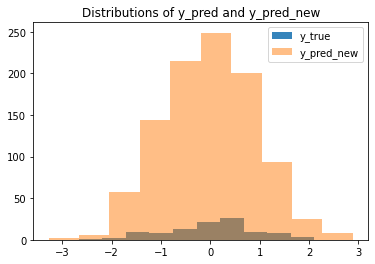

In [92]:
plt.hist(y_pred, alpha = 0.9, label='y_true')
plt.hist(y_pred_new, alpha = 0.5, label='y_pred_new')
plt.title('Distributions of y_pred and y_pred_new')
plt.legend()
plt.show()

## modeling stages:

- Do the LOOCV nested, for hyperparam optimization
- once best params determined, test best param models for estimating RMSE using LOOCV outer loop
- Fit the best performing model with all the training data - use this model to predict X_new

In [4]:
# only 4 out of 100 cols are complete.
# the rest contain NA's and require a decision on how to handle it
df.loc[:,df.isna().sum(axis=0) == 0].columns

Index(['y', ' x_ 1', ' x_ 2', ' x_ 3', ' x_ 4', ' x_ 5', ' x_ 6', ' x_ 7',
       ' x_ 8', ' x_ 9',
       ...
       ' x_91', ' x_92', ' x_93', ' x_94', ' x_95', ' C_ 1', ' C_ 2', ' C_ 3',
       ' C_ 4', ' C_ 5'],
      dtype='object', length=101)

In [6]:
df

,y,x_ 1,x_ 2,x_ 3,x_ 4,x_ 5,x_ 6,x_ 7,x_ 8,x_ 9,...,x_91,x_92,x_93,x_94,x_95,C_ 1,C_ 2,C_ 3,C_ 4,C_ 5
0,90.685036,NaN,NaN,-3.978178,-1.504027,-14.986790,0.651581,-37.878245,16.213807,-3.965437,...,-7.032047,6.319109,NaN,26.197445,-9.913837,H,H,I,K,J
1,60.844445,26.204958,11.185962,-8.247602,-3.875866,-11.329702,2.637900,-39.617497,NaN,-2.442164,...,-13.437474,NaN,-12.880342,25.924603,-7.015803,K,H,J,G,G
2,18.062345,18.560873,11.355342,-9.370161,-3.745315,-16.292421,-1.831774,-37.584605,14.411348,-2.376175,...,-12.291624,2.664209,-15.803518,24.293073,-14.795709,I,H,G,H,G
3,-8.139839,31.896496,10.069040,-9.484426,-1.512786,-11.421909,-5.649180,-42.830037,18.403197,-7.791762,...,-13.253436,5.004891,-13.879328,25.954304,-9.365574,NaN,H,K,K,G
4,-4.994792,25.400286,NaN,-3.600959,-2.615988,-15.455676,-4.950816,-39.932456,NaN,-7.341165,...,NaN,5.101262,-16.938532,22.611184,-17.240003,G,H,H,K,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,12.574444,24.821083,14.377228,-7.899269,-5.531786,NaN,-3.732251,NaN,15.752089,NaN,...,-21.322369,4.998234,NaN,NaN,-11.750148,I,H,J,G,G
96,-109.414997,20.848176,9.238049,-11.921478,-6.374971,-18.648810,-3.019048,-41.358696,8.435083,-5.864114,...,NaN,2.597797,-17.732465,20.164049,-15.924279,I,H,K,I,K
97,-11.548116,27.160523,10.134287,-10.920363,-3.231409,-18.474369,-2.431349,-38.280634,21.150995,-2.531643,...,-13.586151,8.293394,-17.020511,23.697288,-10.619427,NaN,H,I,K,J
98,-35.263761,20.391153,10.180320,NaN,-5.296246,-17.612480,-6.472314,-38.292821,12.740686,NaN,...,-16.653055,NaN,-17.575742,22.101534,-18.731196,I,H,K,H,G


In [7]:
X = prep_X(df)

In [9]:
X

,y,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_91,x_92,x_93,x_94,x_95,C_1,C_2,C_3,C_4,C_5
0,90.685036,NaN,NaN,-3.978178,-1.504027,-14.986790,0.651581,-37.878245,16.213807,-3.965437,...,-7.032047,6.319109,NaN,26.197445,-9.913837,H,H,I,K,J
1,60.844445,26.204958,11.185962,-8.247602,-3.875866,-11.329702,2.637900,-39.617497,NaN,-2.442164,...,-13.437474,NaN,-12.880342,25.924603,-7.015803,K,H,J,G,G
2,18.062345,18.560873,11.355342,-9.370161,-3.745315,-16.292421,-1.831774,-37.584605,14.411348,-2.376175,...,-12.291624,2.664209,-15.803518,24.293073,-14.795709,I,H,G,H,G
3,-8.139839,31.896496,10.069040,-9.484426,-1.512786,-11.421909,-5.649180,-42.830037,18.403197,-7.791762,...,-13.253436,5.004891,-13.879328,25.954304,-9.365574,NaN,H,K,K,G
4,-4.994792,25.400286,NaN,-3.600959,-2.615988,-15.455676,-4.950816,-39.932456,NaN,-7.341165,...,NaN,5.101262,-16.938532,22.611184,-17.240003,G,H,H,K,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,12.574444,24.821083,14.377228,-7.899269,-5.531786,NaN,-3.732251,NaN,15.752089,NaN,...,-21.322369,4.998234,NaN,NaN,-11.750148,I,H,J,G,G
96,-109.414997,20.848176,9.238049,-11.921478,-6.374971,-18.648810,-3.019048,-41.358696,8.435083,-5.864114,...,NaN,2.597797,-17.732465,20.164049,-15.924279,I,H,K,I,K
97,-11.548116,27.160523,10.134287,-10.920363,-3.231409,-18.474369,-2.431349,-38.280634,21.150995,-2.531643,...,-13.586151,8.293394,-17.020511,23.697288,-10.619427,NaN,H,I,K,J
98,-35.263761,20.391153,10.180320,NaN,-5.296246,-17.612480,-6.472314,-38.292821,12.740686,NaN,...,-16.653055,NaN,-17.575742,22.101534,-18.731196,I,H,K,H,G


In [11]:
np.sum(np.any(X.isna(), axis=0))

96

In [16]:
col_nan = X.columns[X.isna().any()]
X_filtered = X[col_nan]

In [17]:
X_filtered.shape

(100, 96)

Text(0, 0.5, '#NA per column')

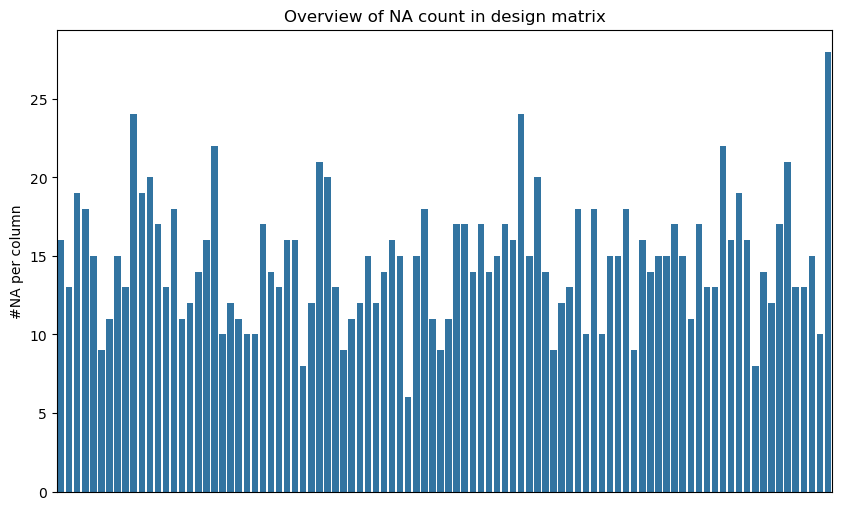

In [18]:
# what to do about the NA's?
nas = X_filtered.isna().sum(axis=0)

fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(
    
    x=nas.index,
    y= nas.values,
    color='tab:blue',

)
plt.title('Overview of NA count in design matrix')
plt.xticks([])
plt.ylabel('#NA per column')

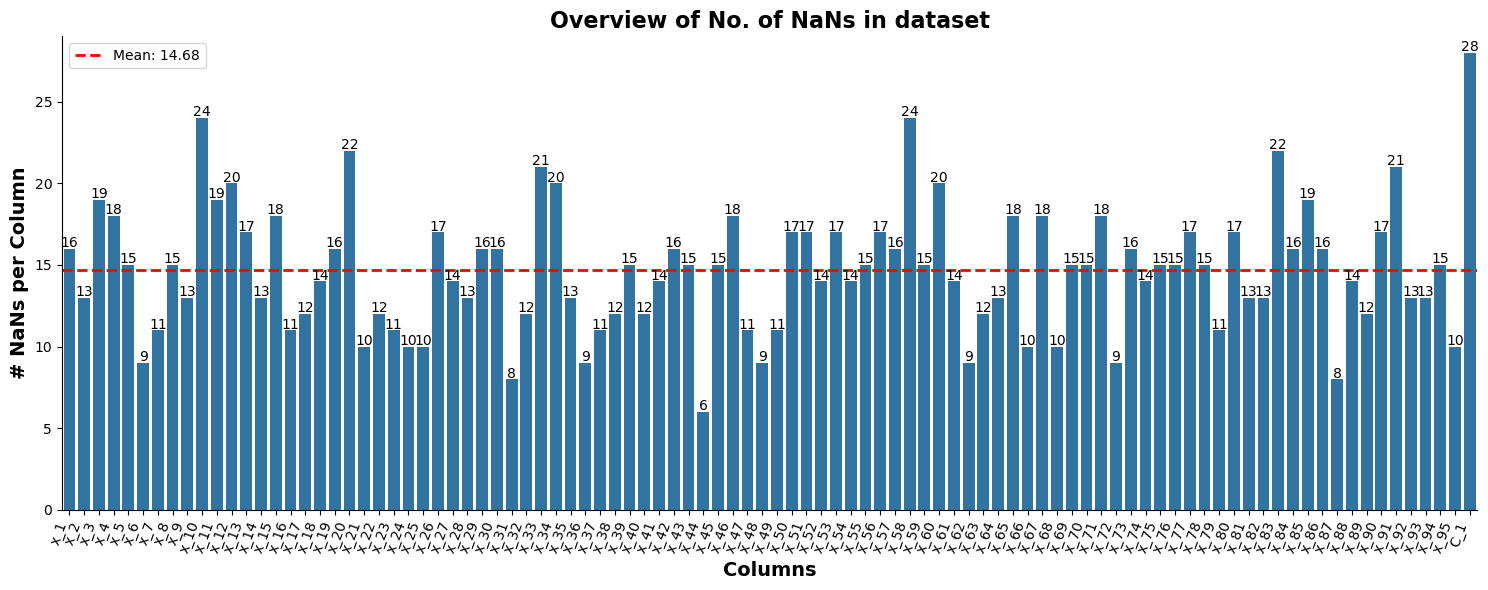

In [43]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=nas.index, y=nas.values, color='#1f77b4')  # Using a visually appealing color palette

# Adding the count above bars
for index, value in enumerate(nas):
    plt.text(x=index, y=value+0.1, s=f"{value}", ha='center')

# Mean line for all bars
mean_nas = nas.mean()
ax.axhline(y=mean_nas, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_nas:.2f}')

# Improving the visual aesthetics
ax.set_title('Overview of No. of NaNs in dataset', fontsize=16, fontweight='bold')
ax.set_xlabel('Columns', fontsize=14, fontweight='bold')
ax.set_ylabel('# NaNs per Column', fontsize=14, fontweight='bold')
ax.set_xticklabels(nas.index, rotation=70, horizontalalignment='right')

ax.set_ylim(0, nas.max() + 1)  # Adjust ylim to fit text labels

sns.despine()  # Remove the top and right spines for a cleaner look
plt.tight_layout()  # Adjust the layout to make sure everything fits without overlapping
plt.legend()  # Show the legend to display the mean line label
plt.savefig('NaNs_per_column')
plt.show()


For any given column 10-25% of data is missing. In total, ~14% of data is missing. In this case, the choice of how to fill NA's will have a significant impact on the models performance. The first, simplest choice is to impute the columns mean or a majority label.

## Use column mean or majority for NA

In [8]:
# look into the categorical attributes
cat_cols = [col for col in X.columns if 'C' in col]
for col in cat_cols:
    print(X[col].value_counts())
    print('-'*10)

 J    23
 G    18
 H    12
 I    11
 K     8
Name: C_1, dtype: int64
----------
 H    100
Name: C_2, dtype: int64
----------
 J    26
 G    21
 K    21
 I    16
 H    16
Name: C_3, dtype: int64
----------
 K    24
 G    24
 J    20
 I    20
 H    12
Name: C_4, dtype: int64
----------
 K    24
 I    24
 J    19
 H    17
 G    16
Name: C_5, dtype: int64
----------


C_1 is the only one missing lables. C_2 is redundant as it only contains a single lable (H), so should not be included in the model.

In [9]:
# fill missing data

X_mean = X.copy()
for col in X_mean.columns:
    if 'x' in col: 
        # impute mean for continuous
        X_mean[col] = X_mean[col].replace(np.nan, X_mean[col].mean())
    else:
        # impute majority group for categorical
        X_mean[col] = X_mean[col].replace(np.nan, X_mean[col].value_counts().index[0]) 

## Scale and encode attribute data

In [10]:
# drop C_2 from cat_cols
cat_cols.remove('C_2')

In [11]:
X_cont = X_mean.loc[:,[col for col in X_mean.columns if 'x' in col]]
X_cont = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_cont), columns=X_cont.columns)
X_scaled = pd.concat([X_cont,pd.get_dummies(X_mean[cat_cols])], axis=1)

In [12]:
X_scaled

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,C_4_ G,C_4_ H,C_4_ I,C_4_ J,C_4_ K,C_5_ G,C_5_ H,C_5_ I,C_5_ J,C_5_ K
0,1.208626e-15,0.000000,2.013601e+00,1.090246,5.439675e-01,1.238584,3.842614e-01,0.319772,3.322680e-01,6.545004e-16,...,0,0,0,0,1,0,0,0,1,0
1,6.983175e-01,-0.144005,5.227784e-01,0.078762,1.958793e+00,1.949235,-4.450169e-01,0.000000,9.135559e-01,4.184132e-01,...,1,0,0,0,0,1,0,0,0,0
2,-1.902184e+00,-0.074197,1.307966e-01,0.134436,3.885536e-02,0.350106,5.242694e-01,-0.327886,9.387376e-01,1.064744e+00,...,0,1,0,0,0,1,0,0,0,0
3,2.634566e+00,-0.604329,9.089690e-02,1.086510,1.923120e+00,-1.015659,-1.976761e+00,1.106461,-1.127875e+00,-7.314475e-01,...,0,0,0,0,1,1,0,0,0,0
4,4.245698e-01,0.000000,2.145321e+00,0.616044,3.625686e-01,-0.765803,-5.951899e-01,0.000000,-9.559252e-01,2.822050e-01,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.275262e-01,1.171230,6.444114e-01,-0.627415,1.374446e-15,-0.329834,-3.387880e-15,0.153868,-6.778659e-16,1.426949e+00,...,1,0,0,0,0,1,0,0,0,0
96,-1.124048e+00,-0.946810,-7.600873e-01,-0.986996,-8.727656e-01,-0.074669,-1.275224e+00,-2.475271,-3.922758e-01,-1.029843e+00,...,0,0,1,0,0,0,0,0,0,1
97,1.023399e+00,-0.577438,-4.105121e-01,0.353594,-8.052793e-01,0.135594,1.924016e-01,2.093797,8.794103e-01,1.365966e+00,...,0,0,0,0,1,0,0,0,1,0
98,-1.279526e+00,-0.558466,-6.202788e-16,-0.526967,-4.718385e-01,-1.310155,1.865909e-01,-0.928186,-6.778659e-16,-1.890162e+00,...,0,1,0,0,0,1,0,0,0,0


# General considerations:

- We should remember that we do the imputations within each fold of the cross-validation.
- We could consider algorithms like decision trees (Random Forest lecture 7/3 or gradient boosting) since it can split the nodes to handle these NaNs and hereby we don't need to impute.
- We should include the terms MCAR, MAR, and NMAR. For example, that NMAR is difficult for us to determine whether this is present due to the lack of domain knowledge in the dataset etc. (https://stefvanbuuren.name/fimd/sec-MCAR.html) (https://medium.com/analytics-vidhya/different-types-of-missing-data-59c87c046bf7). This also makes it difficult for us to choose the correct imputation. It's also a bit difficult to check for MAR since we have 100 variables and we don't know what the different variables are (like the actual meaning of the given variable). In other words, we don't know which variables that are logically related to each other such as function of the lungs and smoking habits. 

# General considerations PART 2:

- Are we allowed to use PCA (we have a lecture about it after hand-in)?
- Due to our limited dataset we could consider a 10 fold cross validation or a leave-one-out?
- For the Random forest I'm looking at the OOB error due to the limited dataset.
- Should we consider another criteria than squared error? Perhaps we could do an outlier investigation? (I have investigated both criterions for the random forest)

# Use KNN imputation for NaN

In [13]:
X_knn = X.copy()
# using same preprocessing as before in order to maintain same recipe (continous variables)
X_knn_cont = X_knn.loc[:,[col for col in X_knn.columns if 'x' in col]]
X_knn_cont = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_knn_cont), columns=X_knn_cont.columns)

# performing one-hot encoding before KNN imputation in order to avoid the model to assume some sort of ordinal relationship
onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')

# one hot encoding
onehot_data = onehot.fit_transform(X_knn[cat_cols])
onehot_columns = onehot.get_feature_names_out()

# new df
onehot_cat_df = pd.DataFrame(onehot_data, columns=onehot_columns)

X_knn_scaled = pd.concat([X_knn_cont,onehot_cat_df], axis=1)
# dropping the nan column
X_knn_scaled = X_knn_scaled.drop(columns={'C_1_nan'})

# KNNImputer
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")

# Apply to dataset
imputed_data = knn_imputer.fit_transform(X_knn_scaled)

imputed_df = pd.DataFrame(imputed_data, columns=X_knn_scaled.columns)

In [15]:
imputed_df

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,C_4_ G,C_4_ H,C_4_ I,C_4_ J,C_4_ K,C_5_ G,C_5_ H,C_5_ I,C_5_ J,C_5_ K
0,-0.173097,0.122542,1.812241,0.987260,0.501513,1.181534,0.362511,0.294815,0.309919,0.827225,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.640019,-0.134319,0.470501,0.071322,1.805918,1.859452,-0.419828,1.056915,0.852108,0.364764,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-1.743380,-0.069207,0.117717,0.121737,0.035823,0.333980,0.494595,-0.302296,0.875596,0.928222,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2.414620,-0.563680,0.081807,0.983877,1.773029,-0.968877,-1.864873,1.020107,-1.052012,-0.637661,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.389125,-0.043864,1.930789,0.557851,0.334272,-0.730530,-0.561501,-0.130242,-0.891628,0.246021,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.208531,1.092451,0.579970,-0.568148,0.468801,-0.314641,0.215397,0.141859,0.219194,1.243985,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
96,-1.030207,-0.883125,-0.684079,-0.893763,-0.804650,-0.071229,-1.203043,-2.282087,-0.365891,-0.897796,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
97,0.937960,-0.538598,-0.369461,0.320193,-0.742431,0.129349,0.181511,1.930385,0.820259,1.190822,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
98,-1.172705,-0.520903,-1.120792,-0.477189,-0.435014,-1.249808,0.176029,-0.855746,-0.947978,-1.647805,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Regression using random forests

## 1st iteration best results (4 different sets of parameters gives the same result):
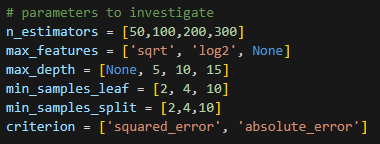


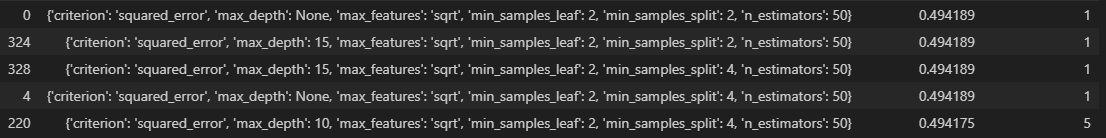

Looks like we should investigate fewer n_estimators and perhaps a higher max_depth (However, we should be aware of overfitting)

## 2nd iteration best results (exact same mean_test_error??):

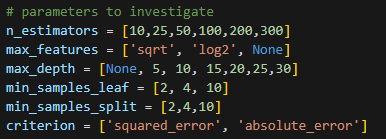

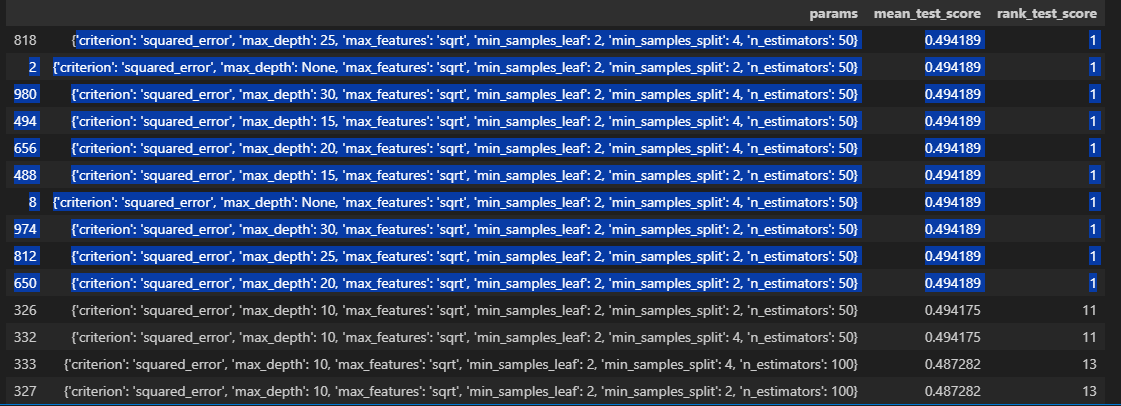


It looks like the max_depth is the most alternating parameter.
However, the investigation of the parameter is not that interesting...
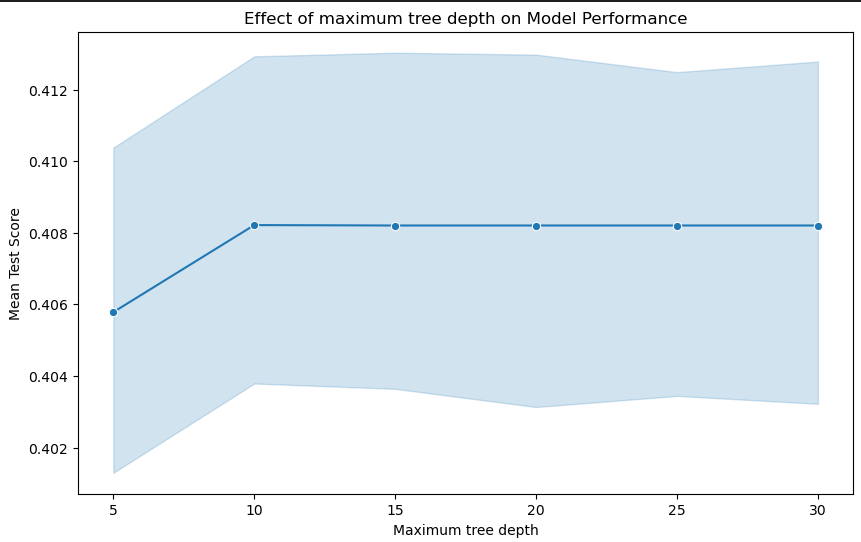

When we look at the performance (training vs. OOB):

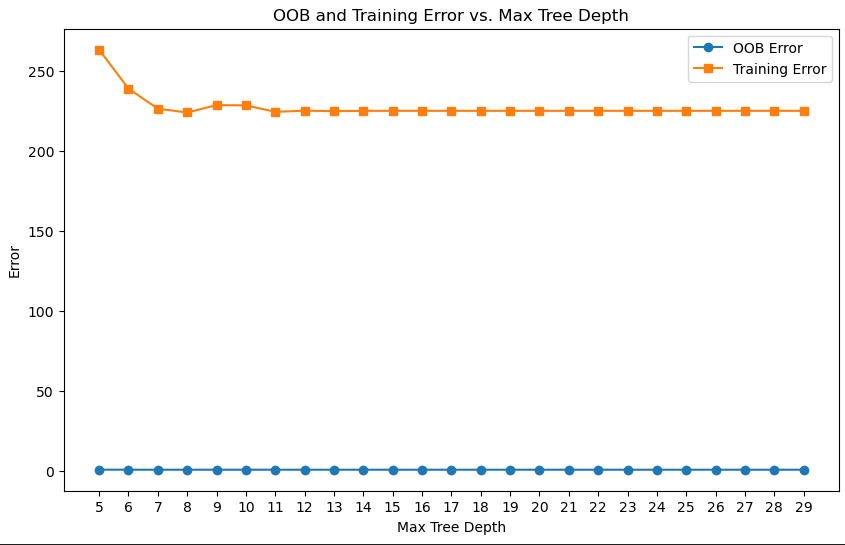

Which is not that exciting either...

# Code:

In [ ]:
clf = RandomForestRegressor(random_state=0,oob_score=True)

# parameters to investigate
n_estimators = [10,25,50,100,200,300]
max_features = ['sqrt', 'log2', None]
max_depth = [None, 5, 10, 15,20,25,30]
min_samples_leaf = [2, 4, 10]
min_samples_split = [2,4,10]
criterion = ['squared_error', 'absolute_error']

param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'criterion': criterion
}

# cv
rf_grid = GridSearchCV(estimator = clf, param_grid = param_grid,cv =5,verbose=2,n_jobs=-1)

# fit grid search model
rf_grid.fit(imputed_df,y)

df_results = pd.DataFrame(rf_grid.cv_results_)

In [ ]:
# Sort by rank or performance
df_sorted = df_results.sort_values(by=['rank_test_score'])

pd.set_option('display.max_colwidth', None)
df_sorted[['params', 'mean_test_score', 'rank_test_score']][:14]

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results, x='param_max_depth', y='mean_test_score', marker='o')
plt.title('Effect of maximum tree depth on Model Performance')
plt.xlabel('Maximum tree depth')
plt.ylabel('Mean Test Score')
plt.show()

In [ ]:
max_depth_range = np.arange(5, 30, 1)
oob_errors = []
training_errors = []

for depth in max_depth_range:
    model = RandomForestRegressor(n_estimators=50, max_depth=depth, oob_score=True, random_state=0)
    model.fit(imputed_df, y)
    
    # Record the OOB error
    oob_error = 1 - model.oob_score_
    oob_errors.append(oob_error)
    
    # Record the training error
    training_predictions = model.predict(imputed_df)
    training_error = np.mean((y - training_predictions) ** 2)  # MSE as the training error
    training_errors.append(training_error)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, oob_errors, label='OOB Error', marker='o')
plt.plot(max_depth_range, training_errors, label='Training Error', marker='s')
plt.xlabel('Max Tree Depth')
plt.ylabel('Error')
plt.title('OOB and Training Error vs. Max Tree Depth')
plt.legend()
plt.xticks(max_depth_range)
plt.show()

# Elastic net

In [19]:
# transform y
y = preprocessing.StandardScaler().fit_transform(np.reshape(y.values, (-1,1)))

In [ ]:
# Since RMSE is the required scoring parameter
# define RMSE scorer function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# make it into a default scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# rename design matrix for ease of use
X = imputed_df.copy()

# model definition
model = ElasticNet()

# choose param grid
param_grid = {
    'alpha': np.logspace(-3, 3, 7),
    'l1_ratio': np.linspace(0, 1, 5)
}

# try LOOCV for both inner and outer loops (could be costly :D)
outer_cv = LeaveOneOut()
inner_cv = 10

nested_scores = []

# Outer Loop
for train_index, test_index in outer_cv.split(X):
    print(test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Grid search with inner loop
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring=rmse_scorer)
    grid_search.fit(X_train, y_train)

    # Evaluate on the test data
    y_pred = grid_search.predict(X_test)
    test_rmse = rmse(y_test, y_pred)
    nested_scores.append(test_rmse)

    print(grid_search.best_estimator_)

# Report nested cross-validation RMSE
nested_rmse = np.mean(nested_scores)
print("Nested CV RMSE:", nested_rmse)



In [21]:
# Report nested cross-validation RMSE
nested_rmse = np.mean(nested_scores)
print("Nested CV RMSE:", nested_rmse)

Nested CV RMSE: 0.34919369478905354
